# MLP
Training auf Hybrid_b17_test 80%  
Validierung auf Hybrid_b17_test 10%   
Test auf Hybrid_b17_test 10% 

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

2024-11-19 14:05:26.681144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 14:05:26.692284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 14:05:26.702270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 14:05:26.705342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 14:05:26.715122: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='31_cnn.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [3]:
# Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
df = pd.read_parquet(hybrid_train_prep_1)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-19 14:05:27 - INFO - Class distribution
Label
DoS Hulk                        158468
BENIGN                          158257
DDoS-LOIC-HTTP                   95144
Infiltration - NMAP Portscan     71767
DoS GoldenEye                     7567
DoS Slowloris                     3859
SSH-BruteForce                    2961
Botnet Ares                        736
Name: count, dtype: int64


(498759, 52)
Index(['Fwd IAT Total', 'Dst Port', 'FIN Flag Count', 'Packet Length Variance',
       'Down/Up Ratio', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'URG Flag Count', 'Bwd Packets/s', 'Total TCP Flow Time',
       'Bwd Bulk Rate Avg', 'Total Length of Fwd Packet', 'Bwd IAT Mean',
       'Bwd Packet/Bulk Avg', 'Fwd IAT Max', 'Protocol', 'Flow IAT Min',
       'Bwd Header Length', 'Active Max', 'Total Fwd Packet',
       'Subflow Bwd Packets', 'Fwd Header Length', 'Fwd Seg Size Min',
       'Fwd RST Flags', 'Idle Std', 'Fwd Packet Length Min',
       'Bwd Init Win Bytes', 'Bwd Packet Length Std', 'RST Flag Count',
       'Fwd Act Data Pkts', 'Subflow Fwd Packets', 'ECE Flag Count',
       'SYN Flag Count', 'Bwd URG Flags', 'Average Packet Size', 'Bwd IAT Max',
       'Bwd PSH Flags', 'Total Length of Bwd Packet', 'Bwd RST Flags',
       'Flow Bytes/s', 'Fwd Bulk Rate Avg', 'Fwd IAT Min', 'Active Std',
       'Packet Length Max', 'Bwd IAT Total', 'Fwd IAT Mean', 

### Trennen von Features und Labels

In [4]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (498759, 51)
Form von y: (498759,)


### Label Encoding für y

In [5]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Skallierung von X

In [6]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

Form von X: (498759, 51)
Form von X_scaled: (498759, 51)


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [7]:
# Aufteilen in Trainings- und temporären Datensatz
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen des temporären Datensatzes in Validierung und Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)

Form von X_train: (399007, 51)
Form von X_val: (49876, 51)
Form von X_test: (49876, 51)


### Überprüfen der Klassenverteilung

In [8]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 126605 Beispiele (31.73%)
  Klasse 1: 589 Beispiele (0.15%)
  Klasse 2: 76115 Beispiele (19.08%)
  Klasse 3: 6054 Beispiele (1.52%)
  Klasse 4: 126774 Beispiele (31.77%)
  Klasse 5: 3087 Beispiele (0.77%)
  Klasse 6: 57414 Beispiele (14.39%)
  Klasse 7: 2369 Beispiele (0.59%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 15826 Beispiele (31.73%)
  Klasse 1: 73 Beispiele (0.15%)
  Klasse 2: 9515 Beispiele (19.08%)
  Klasse 3: 756 Beispiele (1.52%)
  Klasse 4: 15847 Beispiele (31.77%)
  Klasse 5: 386 Beispiele (0.77%)
  Klasse 6: 7177 Beispiele (14.39%)
  Klasse 7: 296 Beispiele (0.59%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 15826 Beispiele (31.73%)
  Klasse 1: 74 Beispiele (0.15%)
  Klasse 2: 9514 Beispiele (19.08%)
  Klasse 3: 757 Beispiele (1.52%)
  Klasse 4: 15847 Beispiele (31.77%)
  Klasse 5: 386 Beispiele (0.77%)
  Klasse 6: 7176 Beispiele (14.39%)
  Klasse 7: 296 Beispiele (0.59%)



 ### Modell erstellen und trainieren

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
num_features = 51  # Anzahl der Spalten in X_scaled
num_classes = len(label_encoder.classes_)  # Anzahl der Klassen

# Definiere das Modell
model = Sequential([
    #Dense(64, input_dim=num_features, activation='relu', kernel_regularizer=l2(0.01)),  # Erste versteckte Schicht mit l2
    Dense(64, input_dim=num_features, activation='relu'),  # Erste versteckte Schicht ohne l2
    Dropout(0.3),  # Vermeidung von Overfitting
    Dense(32, activation='relu'),  # Zweite versteckte Schicht
    Dense(num_classes, activation='softmax')  # Ausgabeschicht
])

# Kompiliere das Modell
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Passend für Integer-kodierte Labels
              metrics=['sparse_categorical_accuracy'])  # Genauigkeit für integer Labels

# Modellübersicht
model.summary()



/home/michi/BA/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732021528.239338  668819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732021528.285860  668819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732021528.285899  668819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732021528.289199  668819 cuda_executor.cc:1001] coul

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,672 (22.16 KB)

 Trainable params: 5,672 (22.16 KB)

 Non-trainable params: 0 (0.00 B)

### Trainieren des Modells

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10


I0000 00:00:1732021529.961336  669063 service.cc:146] XLA service 0x7f363c00b520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732021529.961362  669063 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-19 14:05:29.972523: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-19 14:05:30.031436: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  186/12469 ━━━━━━━━━━━━━━━━━━━━ 10s 817us/step - loss: 1.4664 - sparse_categorical_accuracy: 0.4851

I0000 00:00:1732021530.618172  669063 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12469/12469 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.0136 - val_sparse_categorical_accuracy: 0.9973
Epoch 2/10
12469/12469 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0169 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.0085 - val_sparse_categorical_accuracy: 0.9979
Epoch 3/10
12469/12469 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0116 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0071 - val_sparse_categorical_accuracy: 0.9982
Epoch 4/10
12469/12469 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0063 - val_sparse_categorical_accuracy: 0.9983
Epoch 5/10
12469/12469 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0080 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.0076 - val_sparse_categorical_accuracy: 0.9983
Epoch 6/10
12469/12469 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0074 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0052 - val_sparse_categorical_ac

### Trainingsverlauf plotten

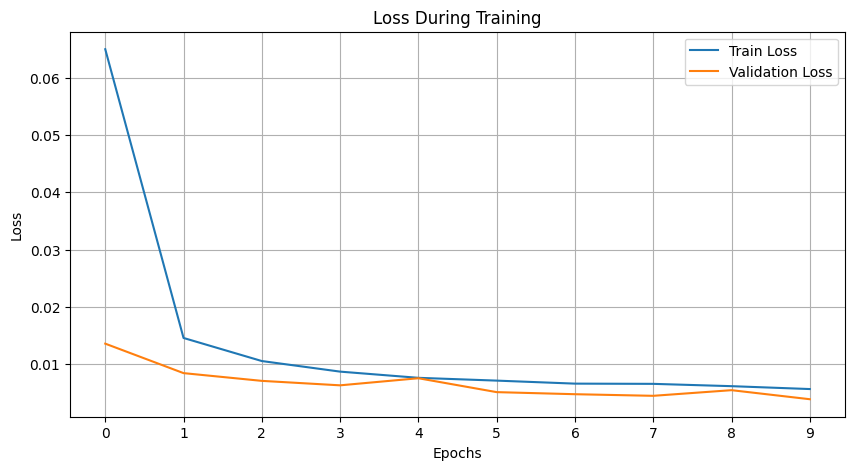

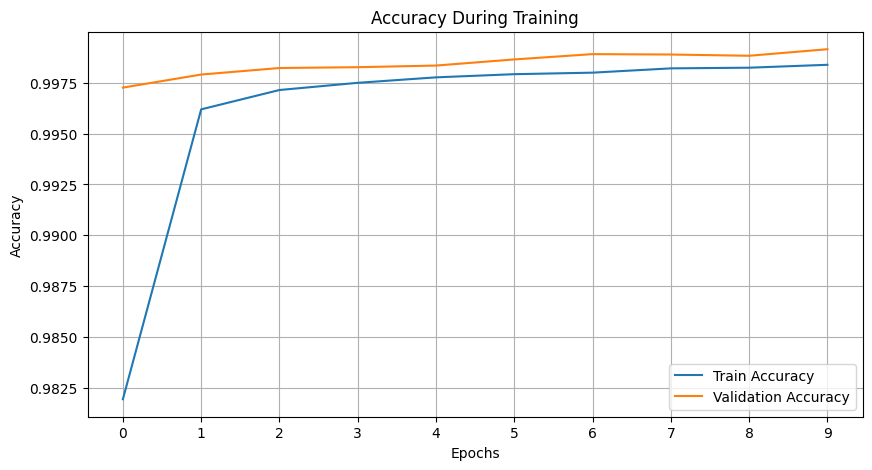

In [11]:
# Trainingsverlauf auslesen
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

# Verlust (Loss) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_loss)))
plt.show()

# Genauigkeit (Accuracy) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_accuracy)))
plt.show()

### Evaluierung des Modells auf dem Testdatensatz - Klassifikationsbericht und eine Konfusionsmatrix

In [13]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)

1559/1559 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step
                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00     15826
                 Botnet Ares       1.00      0.99      0.99        74
              DDoS-LOIC-HTTP       1.00      1.00      1.00      9514
               DoS GoldenEye       1.00      1.00      1.00       757
                    DoS Hulk       1.00      1.00      1.00     15847
               DoS Slowloris       1.00      0.99      0.99       386
Infiltration - NMAP Portscan       1.00      1.00      1.00      7176
              SSH-BruteForce       0.99      1.00      0.99       296

                    accuracy                           1.00     49876
                   macro avg       1.00      1.00      1.00     49876
                weighted avg       1.00      1.00      1.00     49876



Visualisierung der Konfusionsmatrix

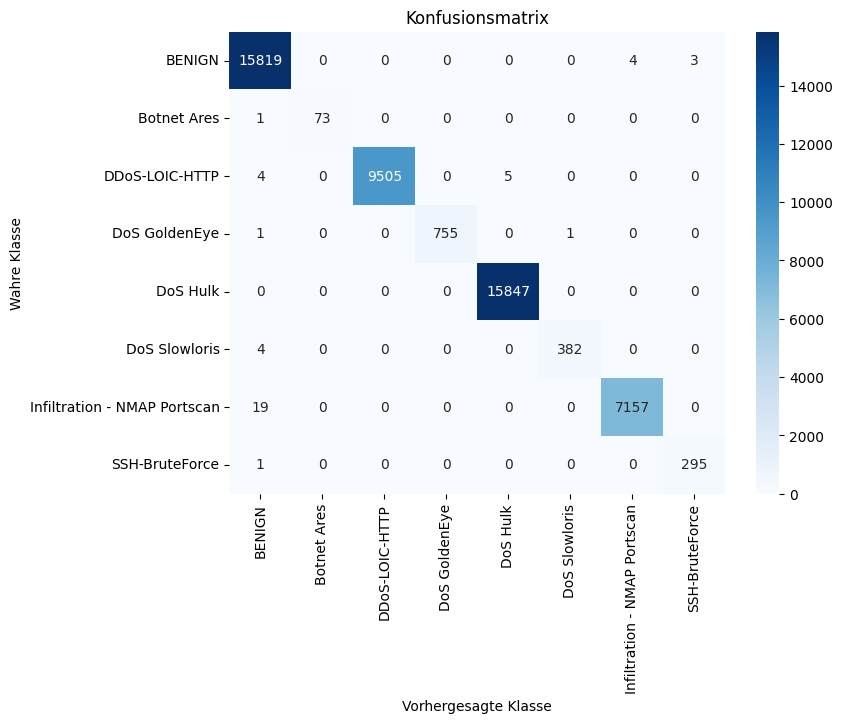

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern des Modells und der Vorverarbeitungsschritte

In [15]:
# Speichern des Modells
model.save('model.keras')

# Speichern des Label Encoders und Scalers
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']